In [2]:
import gmplot
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import shapely
import mplleaflet

import cPickle as pickle

from mpl_toolkits.basemap import Basemap

In [43]:
sf = gpd.read_file('../map_visualization/2010_census_tracts_neighborhoods/census_tracts.shp')
sf = sf.to_crs({'init': 'epsg:4326'})

In [44]:
assault = assault.reset_index(drop=True)
assault.head(1)

,category,descript,dayofweek,time,pddistrict,resolution,address_x,x,y,location,...,race_white,race_black,race_native,race_asian,race_hawaiian_pislander,race_others,race_his_lat,median_income,median_home_value,median_rent
0,assault,battery,friday,08:00,northern,"arrest, booked",union st / gough st,-122.427271,37.798134,"(37.7981336020854, -122.427270640646)",...,21346.0,321.0,26.0,2735.0,15.0,260.0,1593.0,112650.0,1000000.0,1838.0


In [77]:
assault = gpd.GeoDataFrame(assault, geometry=assault.apply(
        lambda srs: shapely.geometry.Point(srs['x'], srs['y']), axis='columns'
    ))

In [78]:
# geometry column is created
assault.head(1)

,category,descript,dayofweek,time,pddistrict,resolution,address_x,x,y,location,...,race_native,race_asian,race_hawaiian_pislander,race_others,race_his_lat,median_income,median_home_value,median_rent,geometry,census_tract
0,assault,battery,friday,08:00,northern,"arrest, booked",union st / gough st,-122.427271,37.798134,"(37.7981336020854, -122.427270640646)",...,26.0,2735.0,15.0,260.0,1593.0,112650.0,1000000.0,1838.0,POINT (-122.427270640646 37.7981336020854),013000


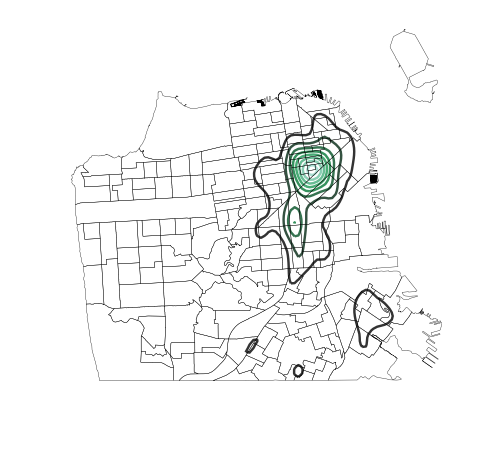

In [79]:
f = plt.figure(figsize=(5, 5))
ax = f.gca()

sf.plot(ax=ax, alpha=0.1, linewidth=0.25, color='white')
sns.kdeplot(data=assault.apply(lambda srs: pd.Series({'x': srs.geometry.x, 'y': srs.geometry.y}), axis='columns'), 
            ax=ax, alpha=1)
ax.set_axis_off()

In [48]:
import numpy as np

def assign_census_tract(df):
    bools = [geom.contains(df['geometry']) for geom in sf['geometry']]
    if True in bools:
        return sf.iloc[bools.index(True)]['tractce10']
    else:
        return np.nan

In [49]:
assault['census_tract'] = assault.apply(assign_census_tract, axis='columns')

In [50]:
assault['census_tract'].value_counts().head()

017601    563
020100    374
061500    313
012501    298
018000    265
Name: census_tract, dtype: int64

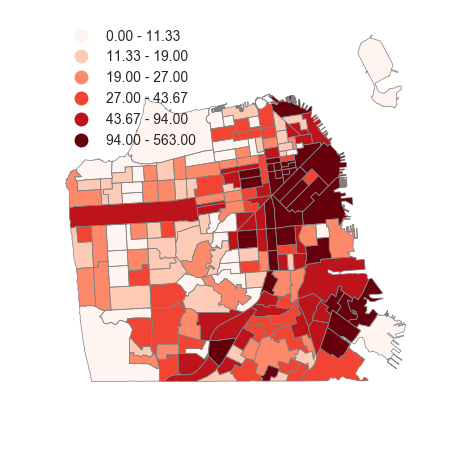

In [51]:
sf['assault'] = sf['tractce10'].map(assault['census_tract'].value_counts())
sf = sf.fillna(0)

f = plt.figure(figsize=(5, 5))
ax = f.gca()
kw = dict(column='assault', k=6, cmap='Reds', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
sf.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()

In [72]:
sum(sf['geometry'].to_crs({'init': 'epsg:4326'}).map(lambda p: p.area*10000))
#square kilometers

124.84698577455622

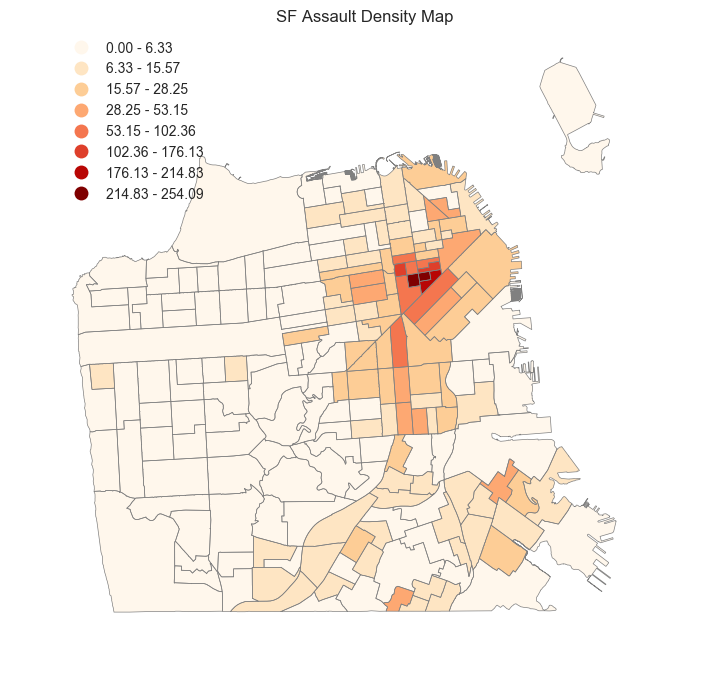

In [162]:
sf['assaultDensity'] = (sf['assault'] / (sf['geometry'].to_crs({'init': 'epsg:4326'}).map(lambda p: p.area*10**5))).fillna(0)

f = plt.figure(figsize=(8, 8))
ax = f.gca()
kw = dict(column='assaultDensity', k=8, cmap='OrRd', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
sf.plot(scheme='Fisher_Jenks',ax=ax, **kw)
ax.set_title('SF Assault Density Map')
ax.set_axis_off()

In [74]:
## spatial weight
import pysal as ps
qW = ps.queen_from_shapefile('../map_visualization/2010_census_tracts_neighborhoods/census_tracts.shp')

('Island id: ', [183])


In [75]:
assault_spatial_lag = ps.lag_spatial(qW, sf['assaultDensity'])
spatial_lag_class = ps.Quantiles(assault_spatial_lag, k=5)

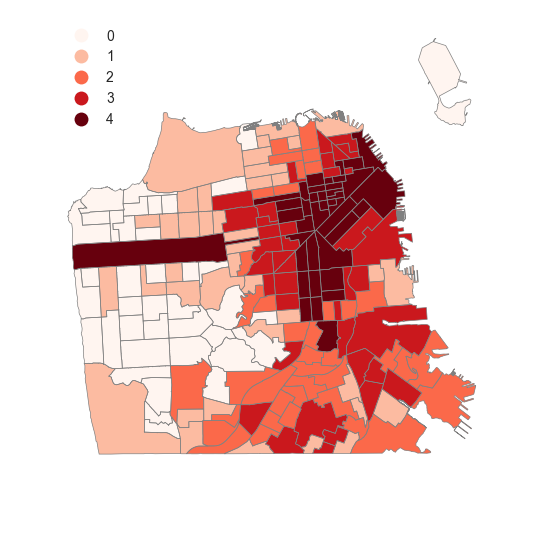

In [76]:
f = plt.figure(figsize=(6,6))
ax = f.gca()

kw = dict(column='spatial_class', k=5, cmap='Reds', alpha=1, legend=True, edgecolor='gray', 
          linewidth=0.5, categorical=True)
sf.assign(spatial_class=spatial_lag_class.yb).plot(ax=ax, **kw)

ax.set_axis_off()

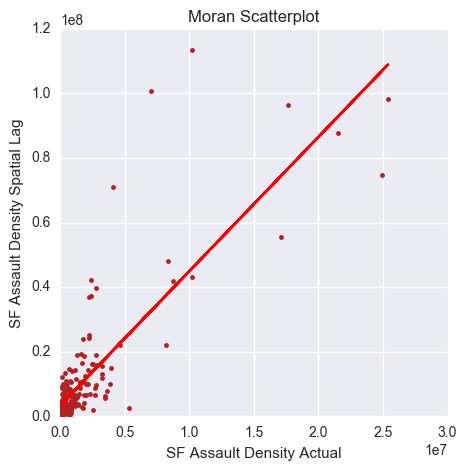

In [57]:
f, ax = plt.subplots(1, figsize=(5, 5))
plt.plot(sf['assaultDensity'], assault_spatial_lag, '.', color='firebrick')

# Calculate and plot a line of best fit.
b,a = np.polyfit(sf['assaultDensity'], assault_spatial_lag, 1)
plt.plot(sf['assaultDensity'], a + b*sf['assaultDensity'], 'r')

plt.title('Moran Scatterplot')
plt.ylabel('SF Assault Density Spatial Lag')
plt.xlabel('SF Assault Density Actual')
plt.show()

In [58]:
moran = ps.Moran(sf['assaultDensity'].values, qW)
moran.I, moran.p_sim

('WARNING: ', 183, ' is an island (no neighbors)')


(0.71454608867246783, 0.001)

## might be stabbed? 

In [83]:
stabbing = stabbing.reset_index(drop=True)
stabbing = gpd.GeoDataFrame(stabbing, geometry=stabbing.apply(
        lambda srs: shapely.geometry.Point(srs['x'], srs['y']), axis='columns'
    ))

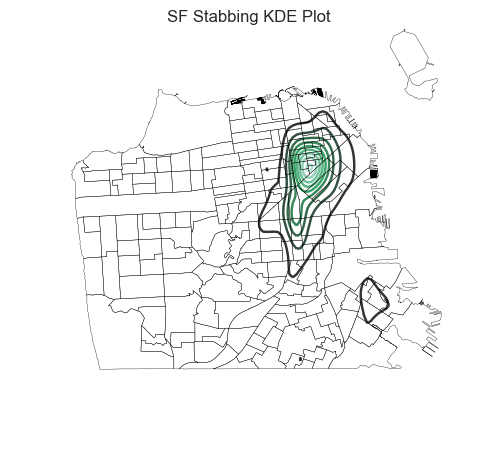

In [87]:
f = plt.figure(figsize=(5, 5))
ax = f.gca()

sf.plot(ax=ax, alpha=0.1, linewidth=0.25, color='white')
sns.kdeplot(data=stabbing.apply(lambda srs: pd.Series({'x': srs.geometry.x, 'y': srs.geometry.y}), axis='columns'), 
            ax=ax, alpha=1)
ax.set_axis_off()
ax.set_title('SF Stabbing KDE Plot')
plt.show()

In [85]:
stabbing['census_tract'] = stabbing.apply(assign_census_tract, axis='columns')

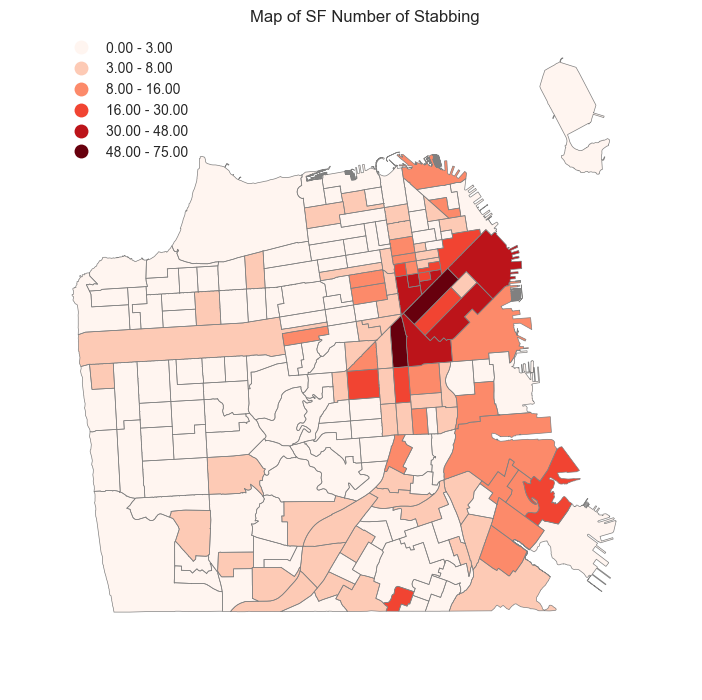

In [149]:
sf['stabbing'] = sf['tractce10'].map(stabbing['census_tract'].value_counts())
sf = sf.fillna(0)

f = plt.figure(figsize=(8, 8))
ax = f.gca()
kw = dict(column='stabbing', k=6, cmap='Reds', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
sf.plot(scheme='Fisher_Jenks', ax=ax, **kw)
ax.set_axis_off()
ax.set_title('Map of SF Number of Stabbing')
plt.show()

In [101]:
sf.columns

Index([          u'geoid',        u'geometry',           u'nhood',
            u'shape_area',       u'shape_len',       u'tractce10',
               u'assault',  u'assaultDensity',        u'stabbing',
       u'stabbingDensity'],
      dtype='object')

In [106]:
sf.groupby('nhood')[['stabbing']].count().sort_values('stabbing', ascending=False).head(20)

,stabbing
nhood,
Sunset/Parkside,14
Mission,13
Bayview Hunters Point,11
Outer Richmond,10
Tenderloin,8
Excelsior,8
Marina,7
West of Twin Peaks,7
Pacific Heights,7


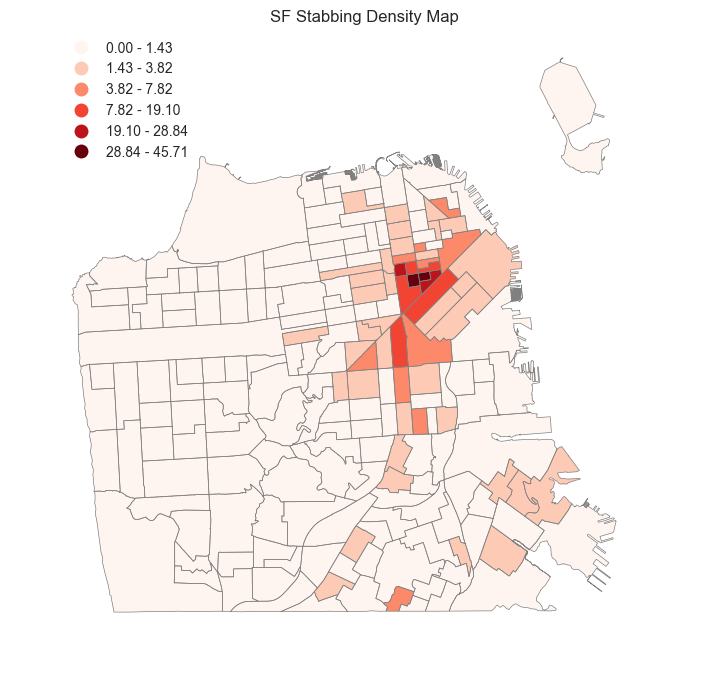

In [140]:
sf['stabbingDensity'] = (sf['stabbing'] / (sf['geometry'].to_crs({'init': 'epsg:4326'}).map(lambda p: p.area*10**5))).fillna(0)

f = plt.figure(figsize=(8, 8))
ax = f.gca()
kw = dict(column='stabbingDensity', k=6, cmap='Reds', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
sf.plot(scheme='Fisher_Jenks',ax=ax, **kw) 
#sf.plot(scheme='Percentiles',ax=ax, **kw)
ax.set_title('SF Stabbing Density Map')
ax.set_axis_off()

In [153]:
stabbing[stabbing.zipcode=='94104'].groupby('hour')['category'].count().sort_values(ascending=False).reset_index()

,hour,category
0,20,2
1,8,2
2,19,1
3,16,1
4,9,1
5,0,1


In [ ]:
##Stabbing2

## auto theft

In [169]:
auto_theft = auto_theft.reset_index(drop=True)
auto_theft = gpd.GeoDataFrame(auto_theft, geometry=auto_theft.apply(
        lambda srs: shapely.geometry.Point(srs['x'], srs['y']), axis='columns'
    ))

In [170]:
auto_theft['census_tract'] = auto_theft.apply(assign_census_tract, axis='columns')

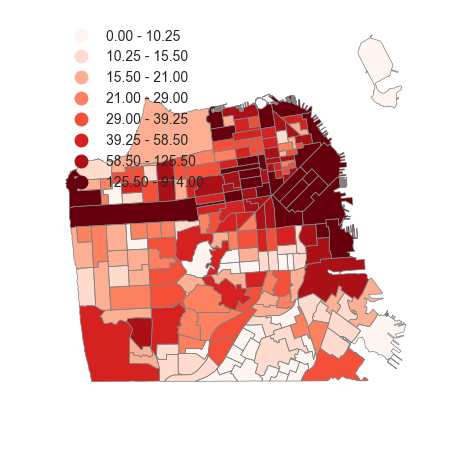

In [172]:
sf['auto_theft'] = sf['tractce10'].map(auto_theft['census_tract'].value_counts())
sf = sf.fillna(0)

f = plt.figure(figsize=(5, 5))
ax = f.gca()
kw = dict(column='auto_theft', k=8, cmap='Reds', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
sf.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()

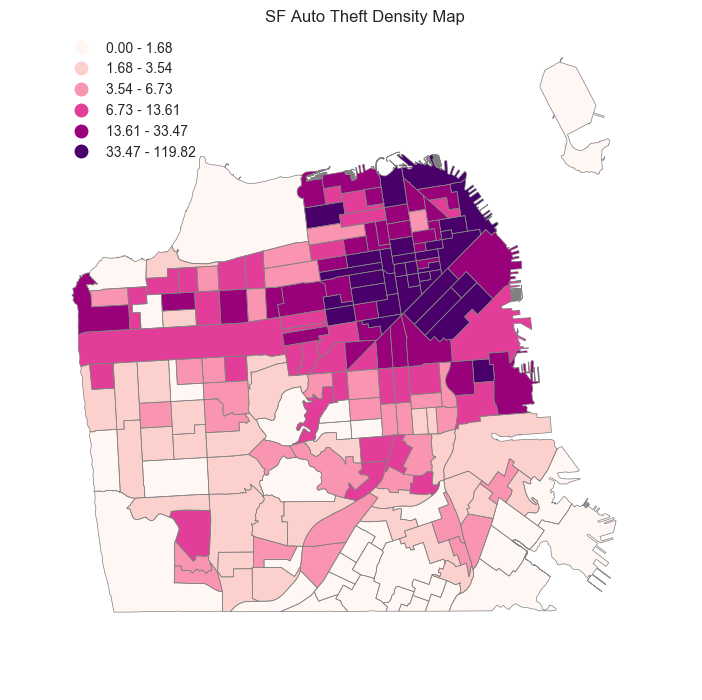

In [179]:
sf['auto_theftDensity'] = (sf['auto_theft'] / (sf['geometry'].to_crs({'init': 'epsg:4326'}).map(lambda p: p.area*10**5))).fillna(0)

f = plt.figure(figsize=(8, 8))
ax = f.gca()
kw = dict(column='auto_theftDensity', k=6, cmap='RdPu', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
#sf.plot(scheme='Fisher_Jenks',ax=ax, **kw)
sf.plot(scheme='QUANTILES',ax=ax, **kw)
ax.set_axis_off()
ax.set_title('SF Auto Theft Density Map')

## load or save work

In [42]:
with open('../final_dataset/assault.pkl', 'rb') as handle:
    assault = pickle.load(handle)

In [80]:
with open('../final_dataset/crime2016_origin_modified_col.pkl', 'rb') as handle:
    crime_map = pickle.load(handle)

In [82]:
with open('../final_dataset/stabbing.pkl', 'rb') as handle:
    stabbing = pickle.load(handle)

In [166]:
auto_theft = crime_map[crime_map.descript=='grand theft from locked auto']